In [147]:
receiver_email = "romtaug@gmail.com"  # Adresse email du destinataire

- Sur la page Leboncoin, faire : `Ctrl+I`
- Aller dans l'onglet "Réseau" et sélectionner **XHR**
- Cliquer sur **Paramètre** puis **"Conserver les journaux"**
- Voici le paramètre API à entrer dans "Filtrer les URL" : `api.leboncoin.fr/finder/search`

- Télécharger l'extension : [UI.Vision](https://ui.vision/#get)
- Importer les 2 fichiers Json sur UI.Vision, cliquer sur **"Play Macro"** et attendre pour chaque fichier, l'un après l'autre
- Ouvrir une nouvelle fenêtre pour changer de fichier et refaire la démarche
- Quand le programme est fini, cliquer sur **Paramètre** → **"Tout enregistrer en tant que HAR"**
- Renommer les fichiers en **"locationLBC.har"** et **"venteLBC.har"**
- Déplacer les fichiers dans le dossier suivant :  
  `PFE\4 Best Real Estate Investment\Emailing\Contacts LBC\Contacts LBC\Contacts LBC\Json`

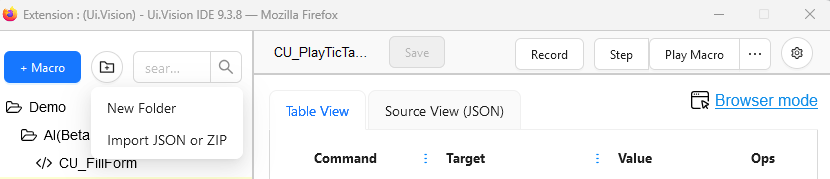
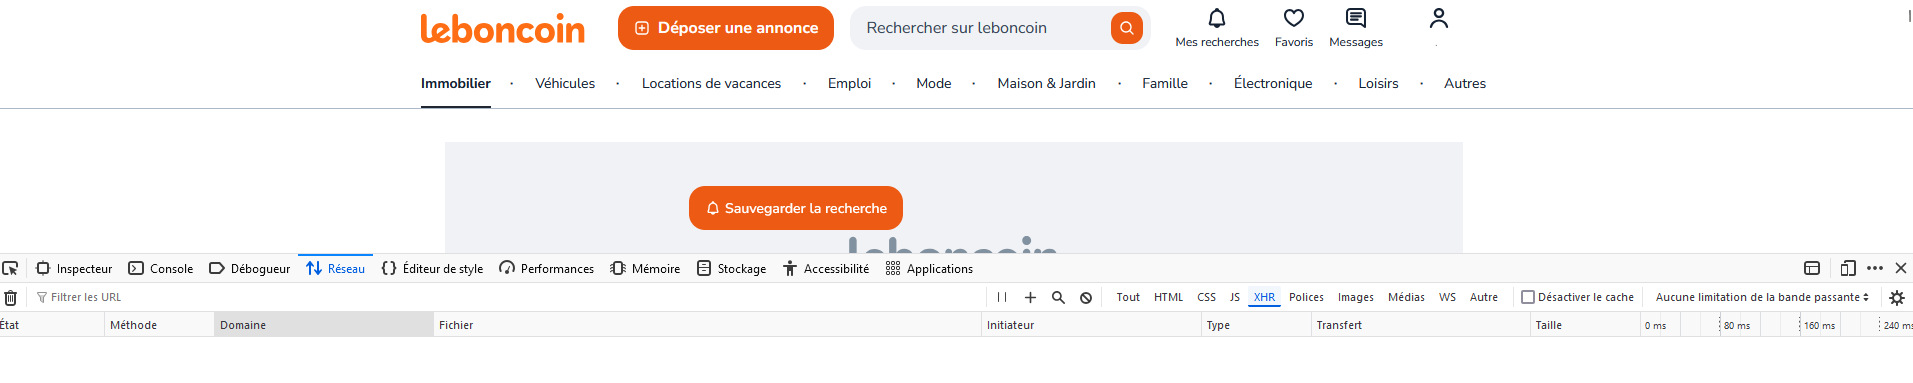

Exécutez le code suivant et le résulat se trouvera dans le fichier Excel avec la date du jour :

Pour les locations :

In [148]:
import os
import pandas as pd
import json
from datetime import datetime

print("Traitement du fichier : Har\\locationLBC.har")
with open("Har\\locationLBC.har", 'r', encoding='utf-8') as f:
    har_data = json.load(f)

entries = har_data.get("log", {}).get("entries", [])
ads = []

for entry in entries:
    request = entry.get("request", {})
    response = entry.get("response", {})
    url = request.get("url", "")

    if "api.leboncoin.fr/finder/search" in url:
        content = response.get("content", {}).get("text", "")
        if content:
            try:
                json_data = json.loads(content)
                ads.extend(json_data.get("ads", []))
            except json.JSONDecodeError:
                print(f"Impossible de décoder le contenu JSON pour l'URL : {url}")

if not ads:
    print("Aucune annonce extraite pour Har\\locationLBC.har.")
else:
    df = pd.DataFrame(ads)

    # Convertir les colonnes contenant des listes ou dictionnaires en chaînes de caractères
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)

    df.drop_duplicates(inplace=True)

    # Ajouter la colonne Classe Énergétique si elle est disponible
    if "attributes" in df.columns:
        df["DPE"] = df["attributes"].apply(
            lambda x: next(
                (attr.get('value_label') for attr in json.loads(x) if attr.get('key') == 'energy_rate'),
                "Non spécifiée"
            ) if isinstance(x, str) else "Non spécifiée"
        )
    else:
        df["DPE"] = "Non spécifiée"

    # Nettoyer et convertir la colonne 'price'
    df['price'] = df['price'].str.strip('[]').astype(float)

    # Extraire la surface habitable (m²) depuis 'attributes'
    df['surface_m2'] = df['attributes'].apply(
        lambda x: next(
            (int(attr.get('value')) for attr in json.loads(x) if attr.get('key') == 'square'),
            None
        ) if isinstance(x, str) else None
    )

    # Extraire city_label, département, région, et le nom de la ville depuis 'location'
    df['city_label'] = df['location'].apply(
        lambda x: json.loads(x).get('city_label') if isinstance(x, str) else None
    )
    df['department'] = df['location'].apply(
        lambda x: json.loads(x).get('department_name') if isinstance(x, str) else None
    )
    df['region'] = df['location'].apply(
        lambda x: json.loads(x).get('region_name') if isinstance(x, str) else None
    )
    df['city'] = df['location'].apply(
        lambda x: json.loads(x).get('city') if isinstance(x, str) else None
    )

    # Supprimer les colonnes 'attributes' et 'location'
    df.drop(columns=['attributes', 'location'], inplace=True)

    # Calculer le prix de location par m²
    df['location_price_per_m2'] = df.apply(
        lambda row: row['price'] / row['surface_m2'] if row['surface_m2'] and row['price'] else None,
        axis=1
    )

    # Créer un nouveau DataFrame avec le prix moyen de location par m² par city_label, le nombre d'annonces et les informations supplémentaires
    df_price_per_m2_by_city = df.groupby('city_label', as_index=False).agg(
        location_price_per_m2=('location_price_per_m2', 'mean'),
        sample_size=('location_price_per_m2', 'size'),
        department=('department', 'first'),
        region=('region', 'first'),
        city=('city', 'first')
    )

    # Réorganiser les colonnes dans l'ordre souhaité
    df_price_per_m2_by_city = df_price_per_m2_by_city[
        ['region', 'department', 'city', 'city_label', 'location_price_per_m2', 'sample_size']
    ]

    # Trier par prix de location au m² décroissant
    df_price_per_m2_by_city = df_price_per_m2_by_city.sort_values(by='location_price_per_m2', ascending=False)

    # Enregistrer dans un fichier Excel
    output_file_path = os.path.join(os.getcwd(), "locationLBC.xlsx")
    df_price_per_m2_by_city.to_excel(output_file_path, index=False)

    print(f"Fichier Excel pour les locations créé : {output_file_path}")

Traitement du fichier : Har\locationLBC.har
Fichier Excel pour les locations créé : h:\Desktop\PFE\4 Best Real Estate Investment\Emailing\Best LBC Opportunities\locationLBC.xlsx


Pour les ventes

In [149]:
import os
import pandas as pd
import json
from datetime import datetime

print("Traitement du fichier : Har\\venteLBC.har")
with open("Har\\venteLBC.har", 'r', encoding='utf-8') as f:
    har_data = json.load(f)

entries = har_data.get("log", {}).get("entries", [])
ads = []

for entry in entries:
    request = entry.get("request", {})
    response = entry.get("response", {})
    url = request.get("url", "")

    if "api.leboncoin.fr/finder/search" in url:
        content = response.get("content", {}).get("text", "")
        if content:
            try:
                json_data = json.loads(content)
                ads.extend(json_data.get("ads", []))
            except json.JSONDecodeError:
                print(f"Impossible de décoder le contenu JSON pour l'URL : {url}")

if not ads:
    print("Aucune annonce extraite pour Har\\venteLBC.har.")
else:
    df = pd.DataFrame(ads)

    # Convertir les colonnes contenant des listes ou dictionnaires en chaînes de caractères
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)

    df.drop_duplicates(inplace=True)

    # Ajouter la colonne Classe Énergétique si elle est disponible
    if "attributes" in df.columns:
        df["DPE"] = df["attributes"].apply(
            lambda x: next(
                (attr.get('value_label') for attr in json.loads(x) if attr.get('key') == 'energy_rate'),
                "Non spécifiée"
            ) if isinstance(x, str) else "Non spécifiée"
        )
    else:
        df["DPE"] = "Non spécifiée"

    # Nettoyer et convertir la colonne 'price'
    df['price'] = df['price'].str.strip('[]').astype(float)

    # Extraire la surface habitable (m²) depuis 'attributes'
    df['surface_m2'] = df['attributes'].apply(
        lambda x: next(
            (int(attr.get('value')) for attr in json.loads(x) if attr.get('key') == 'square'),
            None
        ) if isinstance(x, str) else None
    )

    # Extraire city_label, département, région, et le nom de la ville depuis 'location'
    df['city_label'] = df['location'].apply(
        lambda x: json.loads(x).get('city_label') if isinstance(x, str) else None
    )
    df['department'] = df['location'].apply(
        lambda x: json.loads(x).get('department_name') if isinstance(x, str) else None
    )
    df['region'] = df['location'].apply(
        lambda x: json.loads(x).get('region_name') if isinstance(x, str) else None
    )
    df['city'] = df['location'].apply(
        lambda x: json.loads(x).get('city') if isinstance(x, str) else None
    )

    # Supprimer les colonnes 'attributes' et 'location'
    df.drop(columns=['attributes', 'location'], inplace=True)

    # Calculer le prix de vente par m²
    df['sale_price_per_m2'] = df.apply(
        lambda row: row['price'] / row['surface_m2'] if row['surface_m2'] and row['price'] else None,
        axis=1
    )

    # Arrondir le prix par m² à 2 décimales
    df['sale_price_per_m2'] = df['sale_price_per_m2'].round(2)

    # Créer un nouveau DataFrame avec le prix moyen de vente par m² par city_label, le nombre d'annonces et les informations supplémentaires
    df_price_per_m2_by_city = df.groupby('city_label', as_index=False).agg(
        sale_price_per_m2=('sale_price_per_m2', 'mean'),
        sample_size=('sale_price_per_m2', 'size'),
        department=('department', 'first'),
        region=('region', 'first'),
        city=('city', 'first')
    )

    # Réorganiser les colonnes dans l'ordre souhaité
    df_price_per_m2_by_city = df_price_per_m2_by_city[
        ['region', 'department', 'city', 'city_label', 'sale_price_per_m2', 'sample_size']
    ]

    # Trier par prix de vente au m² décroissant
    df_price_per_m2_by_city = df_price_per_m2_by_city.sort_values(by='sale_price_per_m2', ascending=False)

    # Enregistrer dans un fichier Excel
    output_file_path = os.path.join(os.getcwd(), "venteLBC.xlsx")
    df_price_per_m2_by_city.to_excel(output_file_path, index=False)

    print(f"Fichier Excel pour les ventes créé : {output_file_path}")

Traitement du fichier : Har\venteLBC.har
Fichier Excel pour les ventes créé : h:\Desktop\PFE\4 Best Real Estate Investment\Emailing\Best LBC Opportunities\venteLBC.xlsx


Pour les annonces

In [150]:
import os
import pandas as pd
import json
from datetime import datetime

print("Traitement du fichier : Har\\venteLBC.har")
with open("Har\\venteLBC.har", 'r', encoding='utf-8') as f:
    har_data = json.load(f)

entries = har_data.get("log", {}).get("entries", [])
ads = []

for entry in entries:
    request = entry.get("request", {})
    response = entry.get("response", {})
    url = request.get("url", "")

    if "api.leboncoin.fr/finder/search" in url:
        content = response.get("content", {}).get("text", "")
        if content:
            try:
                json_data = json.loads(content)
                ads.extend(json_data.get("ads", []))
            except json.JSONDecodeError:
                print(f"Impossible de décoder le contenu JSON pour l'URL : {url}")

if not ads:
    print("Aucune annonce extraite pour Har\\venteLBC.har.")
else:
    df = pd.DataFrame(ads)

    # Convertir les colonnes contenant des listes ou dictionnaires en chaînes de caractères
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (list, dict))).any():
            df[col] = df[col].apply(lambda x: json.dumps(x) if isinstance(x, (list, dict)) else x)

    df.drop_duplicates(inplace=True)

    # Ajouter la colonne Classe Énergétique si elle est disponible
    if "attributes" in df.columns:
        df["DPE"] = df["attributes"].apply(
            lambda x: next(
                (attr.get('value_label') for attr in json.loads(x) if attr.get('key') == 'energy_rate'),
                "Non spécifiée"
            ) if isinstance(x, str) else "Non spécifiée"
        )
    else:
        df["DPE"] = "Non spécifiée"

    # Identifier si l'annonce est une maison ou un appartement
    df['Type'] = df["attributes"].apply(
        lambda x: next(
            (attr.get('value_label') for attr in json.loads(x) if attr.get('key') == 'real_estate_type'),
            "Inconnu"
        ) if isinstance(x, str) else "Inconnu"
    )

    # Identifier si un téléphone est disponible
    df['HAS_PHONE'] = df['has_phone'].apply(lambda x: "Oui" if bool(x) and pd.notna(x) else "Non")

    # Nettoyer et convertir la colonne 'price'
    df['price'] = df['price'].str.strip('[]').astype(float)

    # Extraire la surface habitable (m²) depuis 'attributes'
    df['surface_m2'] = df['attributes'].apply(
        lambda x: next(
            (int(attr.get('value')) for attr in json.loads(x) if attr.get('key') == 'square'),
            None
        ) if isinstance(x, str) else None
    )

    # Extraire city_label, département, région, et le nom de la ville depuis 'location'
    df['city_label'] = df['location'].apply(
        lambda x: json.loads(x).get('city_label') if isinstance(x, str) else None
    )
    df['department'] = df['location'].apply(
        lambda x: json.loads(x).get('department_name') if isinstance(x, str) else None
    )
    df['region'] = df['location'].apply(
        lambda x: json.loads(x).get('region_name') if isinstance(x, str) else None
    )
    df['city'] = df['location'].apply(
        lambda x: json.loads(x).get('city') if isinstance(x, str) else None
    )

    # Supprimer les colonnes 'attributes' et 'location'
    df.drop(columns=['attributes', 'location'], inplace=True)

    # Calculer le prix de vente par m²
    df['sale_price_per_m2'] = df.apply(
        lambda row: row['price'] / row['surface_m2'] if row['surface_m2'] and row['price'] else None,
        axis=1
    )

    # Arrondir le prix par m² à 2 décimales
    df['sale_price_per_m2'] = df['sale_price_per_m2'].round(2)

    # Charger le fichier locationLBC.xlsx
    location_data = pd.read_excel("locationLBC.xlsx")

    # Fusionner les données sur 'city_label'
    df = df.merge(location_data[['city_label', 'location_price_per_m2', 'sample_size']], on='city_label', how='left')

    # Calculer la rentabilité brute
    df['gross_rent_yield (en %)'] = df.apply(
        lambda row: ((row['location_price_per_m2'] * 12) / row['sale_price_per_m2'] * 100)
        if row['sale_price_per_m2'] and row['location_price_per_m2'] else None,
        axis=1
    )

    # Arrondir la rentabilité brute à 2 décimales
    df['gross_rent_yield (en %)'] = df['gross_rent_yield (en %)'].round(2)

    # Ajouter une colonne pour l'échantillon de détermination
    df['rent_sample_size'] = df.apply(
        lambda row: location_data.loc[location_data['city_label'] == row['city_label'], 'sample_size'].iloc[0]
        if row['city_label'] in location_data['city_label'].values else None,
        axis=1
    )

    # Filtrer les colonnes pour garder uniquement les informations pertinentes
    df_filtered = df[['region', 'department', 'city', 'city_label', 'price', 'DPE', 'Type', 'surface_m2',
                      'location_price_per_m2', 'sale_price_per_m2', 'HAS_PHONE', 'gross_rent_yield (en %)', 'url', 'rent_sample_size']]

    # Trier les données par rentabilité brute décroissante
    df_filtered = df_filtered.sort_values(by='gross_rent_yield (en %)', ascending=False)

    # Enregistrer dans un fichier Excel avec hyperliens cliquables
    output_file_path = os.path.join(os.getcwd(), "vente_rent_yield.xlsx")
    with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
        df_filtered.to_excel(writer, index=False, sheet_name='Rentabilité')
        workbook = writer.book
        worksheet = writer.sheets['Rentabilité']

        # Ajouter les hyperliens dans la colonne URL
        url_col_index = df_filtered.columns.get_loc("url") + 1
        for row_num, url in enumerate(df_filtered['url'], start=2):
            if pd.notna(url):
                worksheet.write_url(row_num - 1, url_col_index - 1, url, string=url)

    print(f"Fichier Excel avec rentabilité brute créé : {output_file_path}")

Traitement du fichier : Har\venteLBC.har
Fichier Excel avec rentabilité brute créé : h:\Desktop\PFE\4 Best Real Estate Investment\Emailing\Best LBC Opportunities\vente_rent_yield.xlsx


In [151]:
import os
import pandas as pd
from datetime import datetime
from openpyxl import load_workbook

# Charger les fichiers Excel existants
location_file = "locationLBC.xlsx"
sale_file = "venteLBC.xlsx"
rent_yield_file = "vente_rent_yield.xlsx"

# Charger les données
location_df = pd.read_excel(location_file)
sale_df = pd.read_excel(sale_file)
rent_yield_df = pd.read_excel(rent_yield_file)

# Renommer les colonnes pour une structure cohérente
location_df.rename(columns={
    'city_label': 'Lieu',
    'location_price_per_m2': 'Prix de location au m² (€)',
    'sample_size': 'Échantillon de données',
    'department': 'Département',
    'region': 'Région',
    'city': 'Ville'
}, inplace=True)

sale_df.rename(columns={
    'sale_price_per_m2': 'Prix de vente au m² (€)',
    'sample_size': 'Échantillon de données',
    'department': 'Département',
    'region': 'Région',
    'city': 'Ville',
    'city_label': 'Lieu',
    'price': 'Prix de vente (€)',
    'surface_m2': 'Surface habitable (m²)'
}, inplace=True)

rent_yield_df.rename(columns={
    'gross_rent_yield (en %)': 'Rentabilité brute estimée (%)',
    'location_price_per_m2': 'Prix de location au m² (€)',
    'rent_sample_size': 'Échantillon de données',
    'region': 'Région',
    'department': 'Département',
    'city': 'Ville',
    'city_label': 'Lieu',
    'price': 'Prix de vente (€)',
    'surface_m2': 'Surface habitable (m²)',
    'sale_price_per_m2': 'Prix de vente au m² (€)',
    'url': 'Lien LebonCoin',
    'HAS_PHONE': 'Téléphone'
}, inplace=True)

# Arrondir toutes les colonnes numériques à 2 décimales
for df in [location_df, sale_df, rent_yield_df]:
    float_cols = df.select_dtypes(include=['float']).columns
    df[float_cols] = df[float_cols].round(2)

# Fusionner les données pour obtenir les moyennes par ville
merged_df = pd.merge(
    location_df[['Lieu', 'Prix de location au m² (€)', 'Département', 'Région', 'Ville', 'Échantillon de données']],
    sale_df[['Lieu', 'Prix de vente au m² (€)', 'Département', 'Région', 'Ville', 'Échantillon de données']],
    on=['Lieu', 'Département', 'Région', 'Ville'],
    how='inner',
    suffixes=(' location', ' vente')
)

# Calculer la rentabilité brute estimée par lieu
merged_df['Rentabilité brute du lieu (%)'] = (
    (merged_df['Prix de location au m² (€)'] * 12) / merged_df['Prix de vente au m² (€)']
) * 100
merged_df['Rentabilité brute du lieu (%)'] = merged_df['Rentabilité brute du lieu (%)'].round(2)

# Ajouter la rentabilité brute estimée du lieu au DataFrame rent_yield_df
rent_yield_df = pd.merge(
    rent_yield_df,
    merged_df[['Lieu', 'Rentabilité brute du lieu (%)']],
    on='Lieu',
    how='left'
)

# Réorganiser les colonnes pour afficher la rentabilité du lieu avant le lien
columns_order = rent_yield_df.columns.tolist()
rentability_lieu_index = columns_order.index('Rentabilité brute du lieu (%)')
url_index = columns_order.index('Lien LebonCoin')
# Placer la rentabilité du lieu juste avant le lien
columns_order.insert(url_index, columns_order.pop(rentability_lieu_index))
rent_yield_df = rent_yield_df[columns_order]

# Trier rent_yield_df par Rentabilité brute estimée (%) en ordre décroissant
rent_yield_df.sort_values(by='Rentabilité brute estimée (%)', ascending=False, inplace=True)
merged_df.sort_values(by='Rentabilité brute du lieu (%)', ascending=False, inplace=True)
sale_df.sort_values(by='Prix de vente au m² (€)', ascending=False, inplace=True)
location_df.sort_values(by='Prix de location au m² (€)', ascending=False, inplace=True)




# Définir le nom et le chemin du fichier Excel de sortie
today = datetime.today().strftime('%Y-%m-%d')
output_file_name = f"Classement_LebonCoin_{today}.xlsx"
output_file_path = os.path.join(os.getcwd(), output_file_name)

# Créer un fichier Excel combiné
with pd.ExcelWriter(output_file_path, engine='xlsxwriter') as writer:
    rent_yield_df.to_excel(writer, index=False, sheet_name='Rentabilité des annonces')
    merged_df[['Région', 'Département', 'Ville', 'Lieu', 'Prix de location au m² (€)', 'Prix de vente au m² (€)', 'Rentabilité brute du lieu (%)', 'Échantillon de données location', 'Échantillon de données vente']].to_excel(writer, index=False, sheet_name='Rentabilité par lieu')
    sale_df.to_excel(writer, index=False, sheet_name='Prix de vente au m² par zone')
    location_df.to_excel(writer, index=False, sheet_name='Prix de location au m² par zone')

# Fonction pour ajuster automatiquement la largeur des colonnes
def adjust_column_width(file_path):
    """
    Ajuste la largeur des colonnes dans un fichier Excel en fonction de la longueur du contenu.
    """
    wb = load_workbook(file_path)
    for sheet_name in wb.sheetnames:
        ws = wb[sheet_name]
        for col in ws.columns:
            max_length = 0
            col_letter = col[0].column_letter
            for cell in col:
                try:
                    if cell.value:
                        max_length = max(max_length, len(str(cell.value)))
                except Exception as e:
                    print(f"Erreur lors de l'ajustement de la colonne {col_letter}: {e}")
            adjusted_width = max_length + 2  # Ajouter une marge pour la lisibilité
            ws.column_dimensions[col_letter].width = adjusted_width
    wb.save(file_path)
    print(f"✅ Largeur des colonnes ajustée pour le fichier : {file_path}")

# Ajuster la largeur des colonnes dans le fichier Excel généré
adjust_column_width(output_file_path)
print(f"Fichier Excel combiné créé avec colonnes ajustées : {output_file_path}")

✅ Largeur des colonnes ajustée pour le fichier : h:\Desktop\PFE\4 Best Real Estate Investment\Emailing\Best LBC Opportunities\Classement_LebonCoin_2024-12-31.xlsx
Fichier Excel combiné créé avec colonnes ajustées : h:\Desktop\PFE\4 Best Real Estate Investment\Emailing\Best LBC Opportunities\Classement_LebonCoin_2024-12-31.xlsx


Envoi de mail

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import os
from datetime import datetime
import sys

# Configuration SMTP
smtp_server = "smtp.gmail.com"
port = 465
sender_email = "taugourdea@cy-tech.fr"
password = "merz kpoh hcwm xjof"  # Mot de passe d'application sécurisé

# Fichiers à attacher
current_date = datetime.now().strftime("%Y-%m-%d")
file_1 = f"Classement_LebonCoin_{current_date}.xlsx"  # Fichier des meilleures annonces
image_files = [
    "Image/logo.png",
    "Image/LMNP.png",
    "Image/qrcode.png"
]

# Vérification de l'existence des fichiers nécessaires
missing_files = [file for file in [file_1] + image_files if not os.path.exists(file)]
if missing_files:
    print(f"🚨 Les fichiers suivants sont introuvables : {', '.join(missing_files)}")
    sys.exit(1)

# Création de l'objet MIMEMultipart pour le message
msg = MIMEMultipart()
msg['From'] = sender_email
msg['To'] = receiver_email
msg['Subject'] = f"🏠 ImmoGains : Les Meilleures Affaires Immobilières du Moment [{current_date}]"

# Corps de l'email
email_body = f"""Bonjour cher invetisseur,

Nous avons le plaisir de vous présenter les meilleures offres immobilières encore disponibles en ligne.

Aperçu des annonces proposées :
- 🏠 Biens immobiliers à fort potentiel
- 💰 Opportunités avec un excellent rapport qualité/prix
- 📈 Annonces avec un rendement locatif attractif en meublé

Ce Google Sheet est conçu pour vous fournir les meilleures opportunités d'investissement immobilier disponibles sur le marché. 
N'oubliez pas de bien négocier votre bien avec les informations données.

Si vous avez des questions ou souhaitez des informations supplémentaires, n'hésitez pas à nous contacter.

Cordialement,

💼 L'équipe ImmoGains
N'hésitez pas à faire un don via PayPal à l'adresse romtaug@gmail.com si cela vous a aidé. 
Accédez à notre guide pour investir ici : https://romtaugs.shinyapps.io/ImmoGains/"""
msg.attach(MIMEText(email_body, 'plain'))

# Fonction pour attacher un fichier
def attach_file(msg, file_path):
    try:
        with open(file_path, "rb") as file:
            attachment = MIMEBase('application', 'octet-stream')
            attachment.set_payload(file.read())
        encoders.encode_base64(attachment)
        filename = os.path.basename(file_path)
        attachment.add_header('Content-Disposition', f'attachment; filename="{filename}"')
        msg.attach(attachment)
        print(f"📎 Fichier joint : {filename}")
    except FileNotFoundError:
        print(f"❌ Erreur : Le fichier {file_path} est introuvable.")

# Attacher le fichier Excel des meilleures annonces
attach_file(msg, file_1)

# Attacher les images
for image in image_files:
    attach_file(msg, image)

# Envoi de l'email
try:
    server = smtplib.SMTP_SSL(smtp_server, port)
    server.login(sender_email, password)
    server.send_message(msg)
    print(f"✅ Email envoyé avec succès à {receiver_email}")
except Exception as e:
    print(f"❌ Erreur lors de l'envoi de l'email : {e}")
finally:
    server.quit()

📎 Fichier joint : Classement_LebonCoin_2024-12-31.xlsx
📎 Fichier joint : logo.png
📎 Fichier joint : LMNP.png
📎 Fichier joint : qrcode.png


In [ ]:
# Gérer le déplacement dans le dossier Historique
historique_folder = os.path.join(os.getcwd(), 'Historique')
if not os.path.exists(historique_folder):
    os.makedirs(historique_folder)

final_path = os.path.join(historique_folder, output_file_name)

# Remplacer le fichier existant, s'il est déjà présent
if os.path.exists(final_path):
    os.remove(final_path)

os.rename(output_file_path, final_path)
print(f"Fichier déplacé dans le dossier Historique : {final_path}")

# Supprimer les fichiers originaux
os.remove(location_file)
os.remove(sale_file)
os.remove(rent_yield_file)
print("Fichiers originaux supprimés.")

PermissionError: [WinError 32] Le processus ne peut pas accéder au fichier car ce fichier est utilisé par un autre processus: 'h:\\Desktop\\PFE\\4 Best Real Estate Investment\\Emailing\\Best LBC Opportunities\\Historique\\Classement_LebonCoin_2024-12-31.xlsx'